In [349]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt

imagePath_L = '../stereo/left.png'
imagePath_R = '../stereo/right.png'
images = [imagePath_L, imagePath_R]

images_ts = ['../data/img/tsukuba_l.jpg', '../data/img/tsukuba_r.jpg']
images_bad = ['../data/img/001_L.png', '../data/img/001_R.png']
images_zed = ['../data/zed/1615274528.9425118_L.jpg', '../data/zed/1615274528.9425118_R.jpg']
box_l_ts = {
    'x': 110,
    'y': 140,
    'w': 100,
    'h': 110
}
box_r_ts = {
    'x': 100,
    'y': 140,
    'w': 100,
    'h': 110
}
box_l_zed = {
    'x': 610,
    'y': 230,
    'w': 100,
    'h': 200
}
box_r_zed = {
    'x': 470,
    'y': 230,
    'w': 110,
    'h': 200
}

In [12]:
def compute_orb_keypoints(filename):
    """
    Reads image from filename and computes ORB keypoints
    Returns image, keypoints and descriptors. 
    """
    # load image
    img = cv2.imread(filename, 0)
    
    # create orb object
    orb = cv2.ORB_create(nfeatures = 1000)
    
    # set parameters 
    orb.setScoreType(cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
    orb.setWTA_K(3)
    
    # detect keypoints
    kp = orb.detect(img,None)

    # for detected keypoints compute descriptors. 
    kp, des = orb.compute(img, kp)
    return img,kp, des 

In [13]:
images_orb = []
kps = []
for img in images:
    img, kp, des = compute_orb_keypoints(img)
    image_orb = cv2.drawKeypoints(img, kp, None)
    kps.append(kp)
    images_orb.append(image_orb)

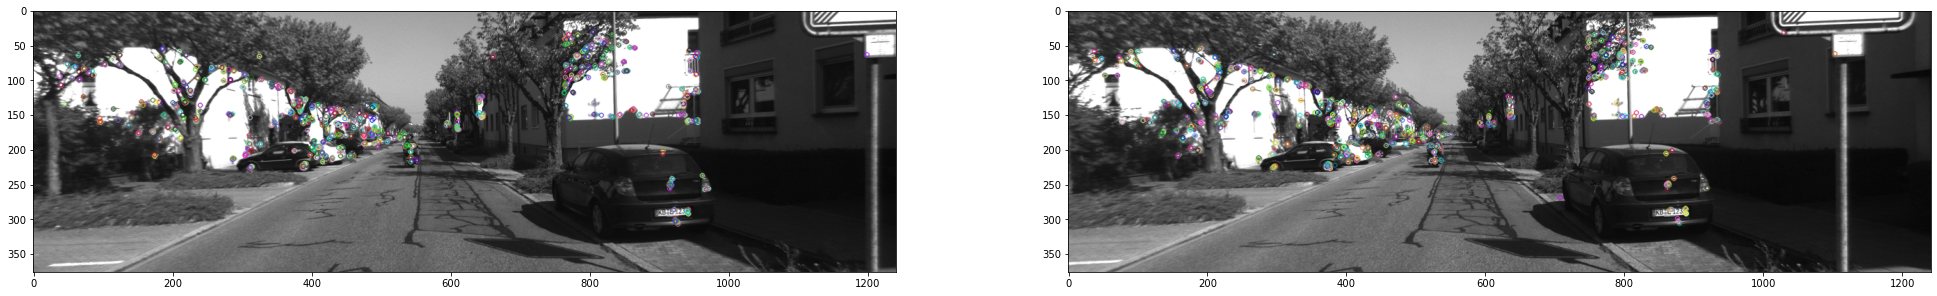

In [14]:
plt.rcParams["figure.figsize"] = (34,12)
plt.subplot(121)
plt.imshow(images_orb[0])
plt.subplot(122)
plt.imshow(images_orb[1])

In [405]:
def match(filename1, filename2, fx, baseline, box_l, box_r):
    img1, kp1, des1 = compute_orb_keypoints(filename1)
    img2, kp2, des2 = compute_orb_keypoints(filename2)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True) 
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    knnMatches = bf.knnMatch(des1, des2, k = 1) # drawMatchesKnn
    matches_new = []
    for m in matches:
        for n in matches:
            if(m != n and m.distance >= n.distance*0.6):
                matches.remove(m)
                break
    for i in matches:
        # 過濾斜線
        if (abs(kp1[i.queryIdx].pt[1] - kp2[i.trainIdx].pt[1]) > 10): 
            continue
        elif (kp1[i.queryIdx].pt[0] < box_l['x'] or kp1[i.queryIdx].pt[0] > box_l['x'] + box_l['w'] or kp1[i.queryIdx].pt[1] < box_l['y'] or kp1[i.queryIdx].pt[1] > box_l['y'] + box_l['h']):
            continue
        matches_new.append(i)
    depth = []
    for i in matches_new:
        print('fx ', fx)
        print('baseline ', baseline)
        print('kp1', kp1[i.queryIdx].pt)
        print('kp2', kp2[i.trainIdx].pt)
        print('dp', (fx * baseline) / (kp1[i.queryIdx].pt[0] - kp2[i.trainIdx].pt[0]))
        depth.append((fx * baseline) / (kp1[i.queryIdx].pt[0] - kp2[i.trainIdx].pt[0]))

    cv2.rectangle(img1,(box_l['x'], box_l['y']),(box_l['x']+box_l['w'], box_l['y']+box_l['h']),(255,255,255),2)
    cv2.rectangle(img2,(box_r['x'], box_r['y']),(box_r['x']+box_r['w'], box_r['y']+box_r['h']),(255,255,255),2)
    img = cv2.drawMatches(img1, kp1, img2, kp2, matches_new, img2, flags=2)
    # img = cv2.drawMatchesknn(img1, kp1, img2, kp2, knnMatches, img2, flags=2)
    
    return img, depth

In [406]:
result, depth = match(*images_ts, 615, 0.1, box_l_ts, box_r_ts)

fx  615
baseline  0.1
kp1 (178.5600128173828, 228.9600067138672)
kp2 (168.48001098632812, 228.9600067138672)
dp 6.101189367895695
fx  615
baseline  0.1
kp1 (164.16001892089844, 233.280029296875)
kp2 (153.79200744628906, 233.280029296875)
dp 5.9317063981468126
fx  615
baseline  0.1
kp1 (126.90435028076172, 206.53060913085938)
kp2 (116.95106506347656, 206.53060913085938)
dp 6.178864430931545
fx  615
baseline  0.1
kp1 (188.6976318359375, 207.3600311279297)
kp2 (178.32962036132812, 207.3600311279297)
dp 5.9317063981468126
fx  615
baseline  0.1
kp1 (116.95106506347656, 184.13572692871094)
kp2 (106.99778747558594, 184.13572692871094)
dp 6.178869167159795
fx  615
baseline  0.1
kp1 (175.57591247558594, 143.3272705078125)
kp2 (164.8263702392578, 143.3272705078125)
dp 5.721173855400138
fx  615
baseline  0.1
kp1 (188.0, 210.0)
kp2 (178.0, 210.0)
dp 6.15
fx  615
baseline  0.1
kp1 (131.04000854492188, 236.16000366210938)
kp2 (120.96000671386719, 236.16000366210938)
dp 6.101189367895695
fx  615
base

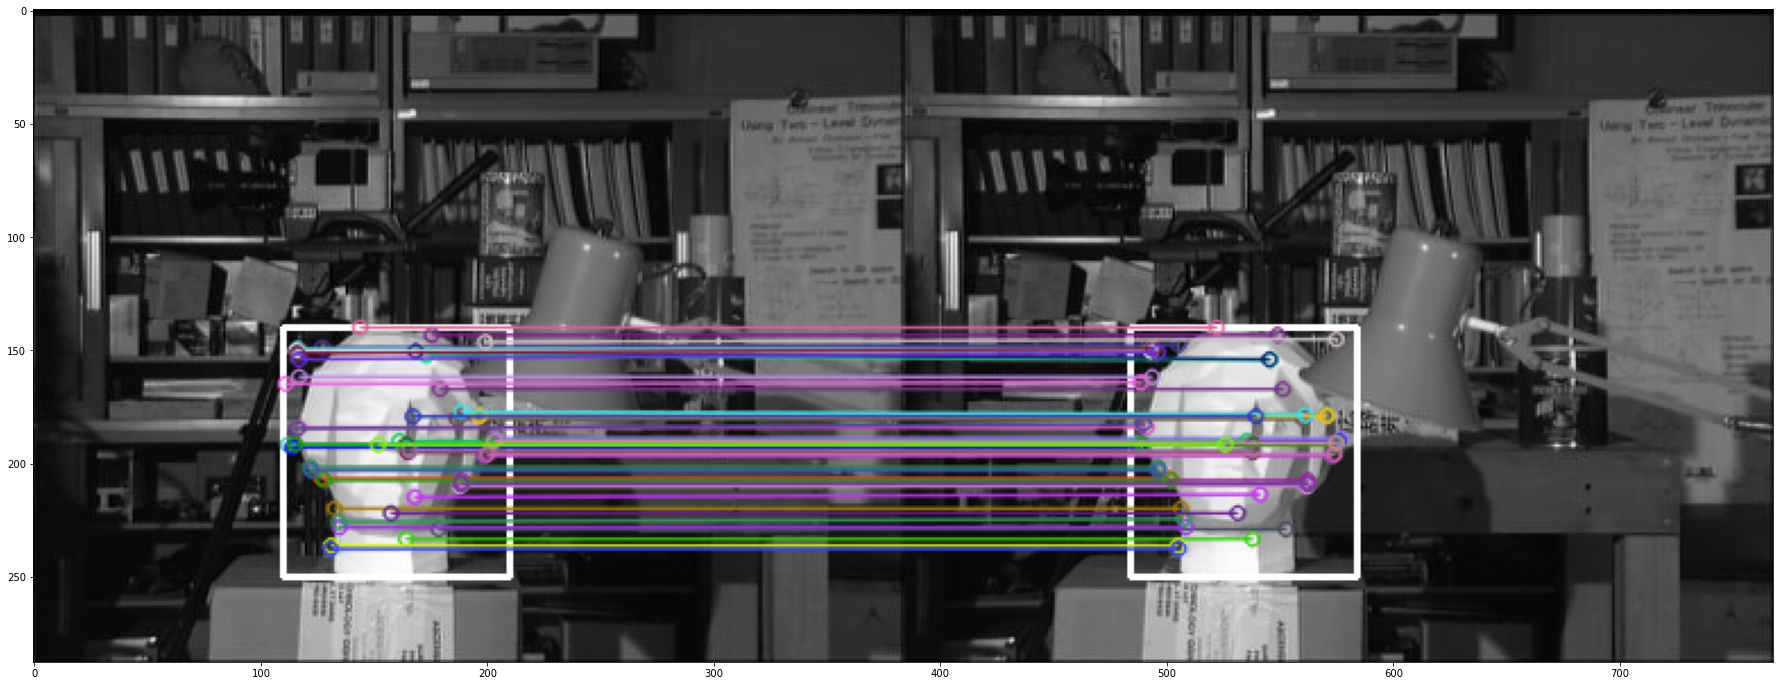

In [407]:
plt.imshow(result)

In [408]:
def showMath(arr):
    print('Median:', np.median(arr))
    print('最小值為 Minimum：',np.quantile(arr, q=0))
    print('較小四分位數為 Q1：', np.quantile(arr, q=0.25))
    print('中位數為 Q2：', np.quantile(arr, q=0.5))
    print('較大四分位數為 Q3：', np.quantile(arr, q=0.75))
    print('最大值為 Maximum：', np.quantile(arr, q=1))
    print('平均數 Mean：', np.mean(arr))

Median: 6.101189367895695
最小值為 Minimum： 5.024507548983308
較小四分位數為 Q1： 5.9317063981468126
中位數為 Q2： 6.101189367895695
較大四分位數為 Q3： 6.178869167159795
最大值為 Maximum： 12.3
平均數 Mean： 6.559543286085505
Median: 6.101189367895695
最小值為 Minimum： 5.438322020540811
較小四分位數為 Q1： 5.9317063981468126
中位數為 Q2： 6.101189367895695
較大四分位數為 Q3： 6.178869167159795
最大值為 Maximum： 8.876387642077098
平均數 Mean： 6.440468189010353


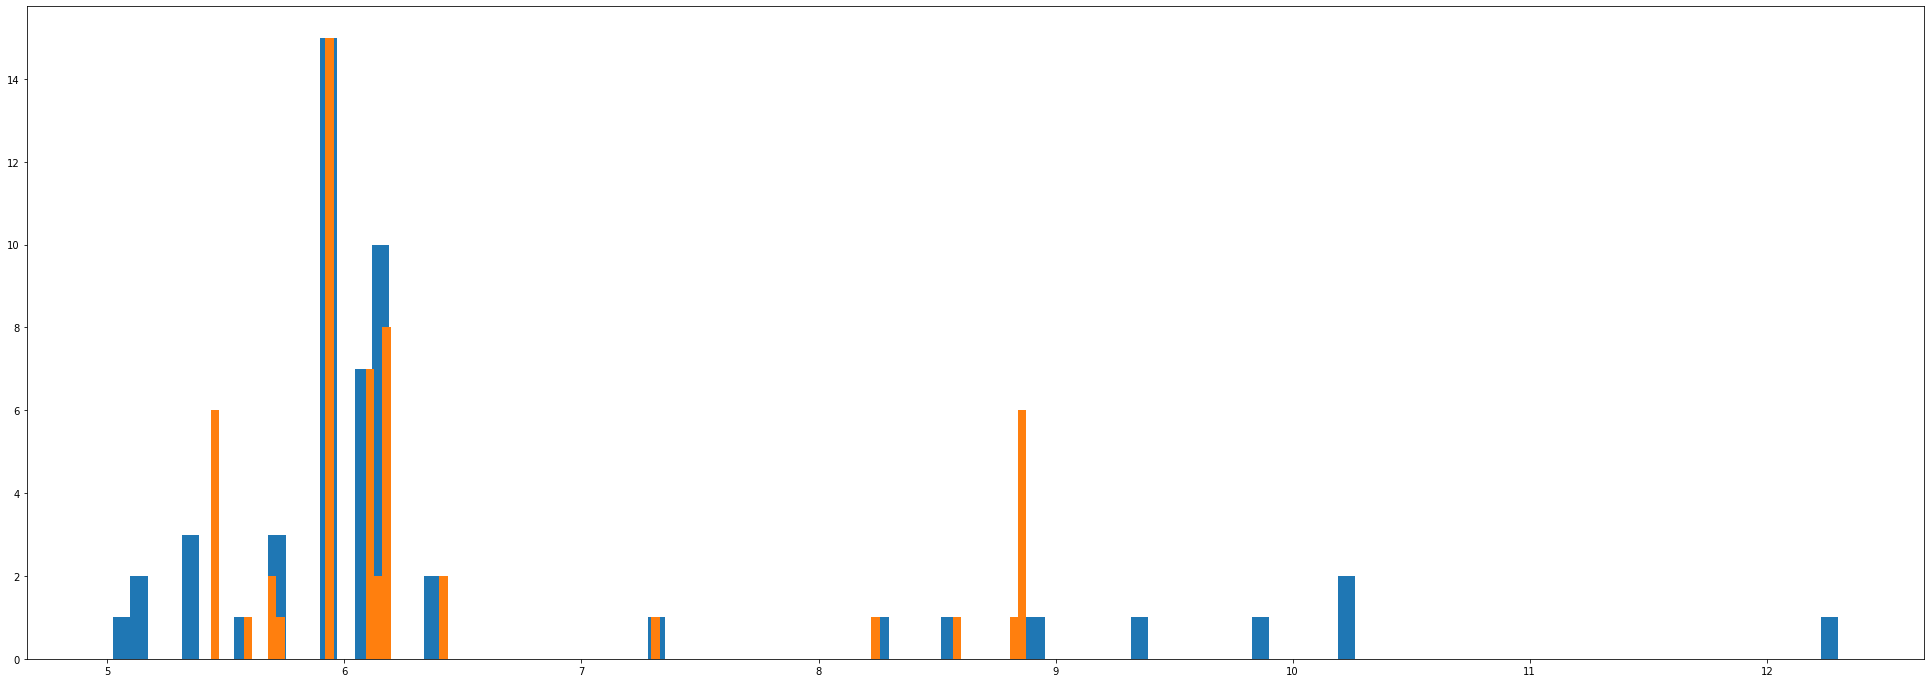

In [409]:
plt.hist(depth, bins = 100)
showMath(depth)
print('==================')
min = np.quantile(depth, q=0.1)
max = np.quantile(depth, q=0.9)
new_depth = np.array(depth).clip(min,max)
plt.hist(new_depth, bins = 100)
showMath(new_depth)

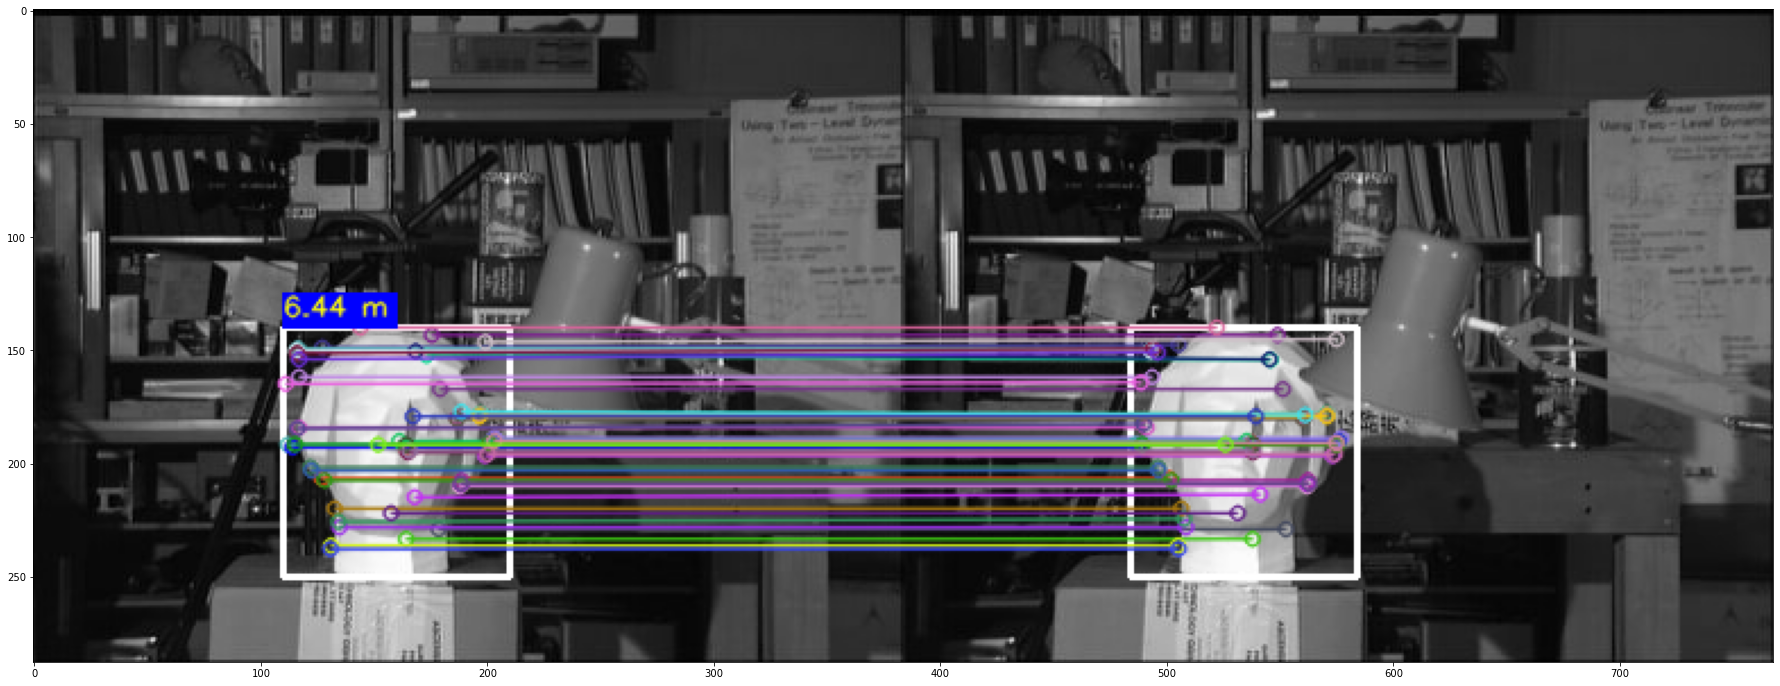

In [410]:
depthMsg = str(round(np.mean(new_depth), 2)) + ' m'
# cv2.putText(影像, 文字, 座標, 字型, 大小, 顏色, 線條寬度, 線條種類)
new_result = result.copy()
cv2.rectangle(new_result, (box_l_ts['x'], box_l_ts['y']), (box_l_ts['x'] + 50, box_l_ts['y'] - 15),(0, 0, 255), thickness=-1)
cv2.putText(new_result, depthMsg, (box_l_ts['x'], box_l_ts['y'] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1, cv2.LINE_AA)
plt.imshow(new_result)

fx  669.371826171875
baseline  0.12033425
kp1 (654.9120483398438, 297.2160339355469)
kp2 (495.93603515625, 297.2160339355469)
dp 0.506669874659025
fx  669.371826171875
baseline  0.12033425
kp1 (672.0, 296.0)
kp2 (513.0, 296.0)
dp 0.5065934381982575
fx  669.371826171875
baseline  0.12033425
kp1 (659.52001953125, 303.84002685546875)
kp2 (499.6800231933594, 303.84002685546875)
dp 0.5039311719155031
fx  669.371826171875
baseline  0.12033425
kp1 (667.6992797851562, 296.52484130859375)
kp2 (508.0320739746094, 296.52484130859375)
dp 0.5044765220548645
fx  669.371826171875
baseline  0.12033425
kp1 (665.2800903320312, 304.1280212402344)
kp2 (506.3040466308594, 304.1280212402344)
dp 0.5066697773969651
fx  669.371826171875
baseline  0.12033425
kp1 (660.0, 300.0)
kp2 (500.4000244140625, 300.0)
dp 0.50468902879093
fx  669.371826171875
baseline  0.12033425
kp1 (665.280029296875, 295.20001220703125)
kp2 (505.4400329589844, 295.20001220703125)
dp 0.5039311719155031
fx  669.371826171875
baseline  0.120

(array([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  4.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  3.,  0.,
        11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,
         0.,  9.,  5.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  6.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  4.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  9.]),
 array([0.50122173, 0.50135423, 0.50148673, 0.50161923, 0.50175173,
        0.50188423, 0.50201673, 0.50214923, 0.50228173, 0.50241423,
        0.50254673, 0.50267923, 0.50281173, 0.50294423, 0.50307673,
        0.50320923, 0.50334173, 0.50347423, 0.50360673, 0.50373923,
        0.50387173, 0.50400423, 0.50413673, 0.50426923, 0.50440173,
        0.50453423, 0.50466673, 0.50479923, 0.50493173, 0.50506423,
        0.50519673, 0.5053

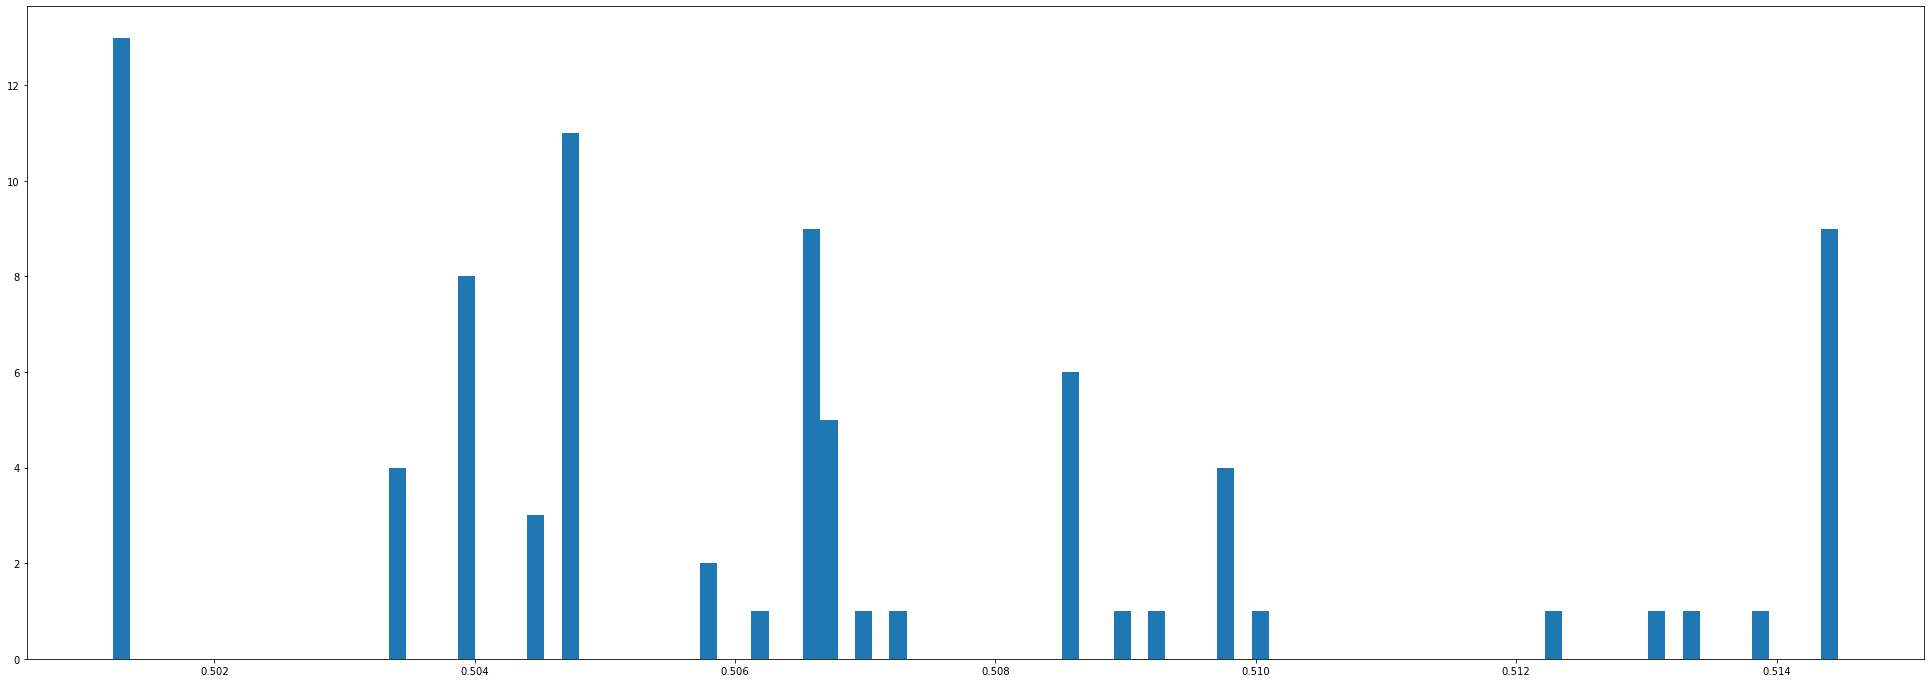

In [386]:
result, depth = match(*images_zed, 669.371826171875, 0.12033425, box_l_zed, box_r_zed)
# plt.imshow(result)
min = np.quantile(depth, q=0.1)
max = np.quantile(depth, q=0.9)
new_depth = np.array(depth).clip(min,max)
plt.hist(new_depth, bins = 100)


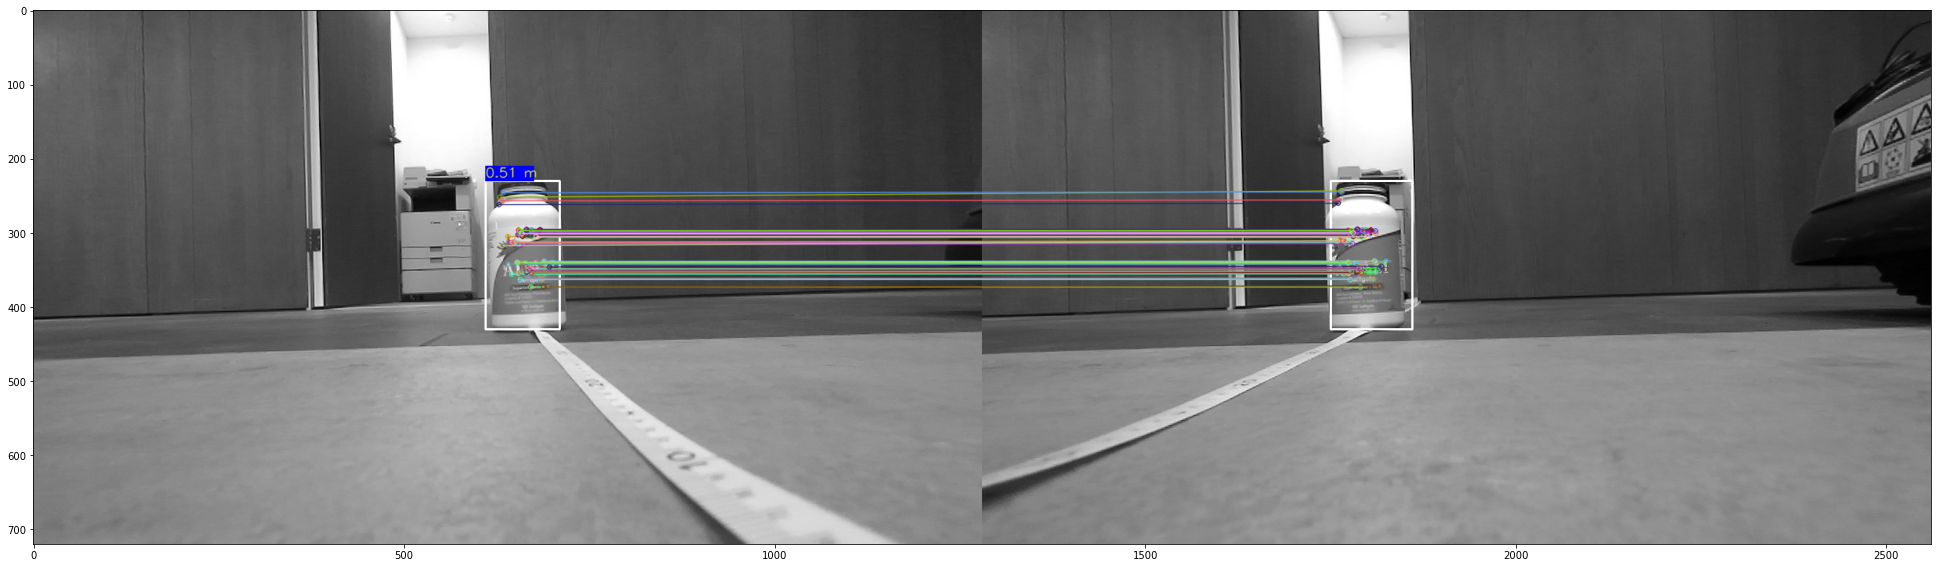

In [398]:
new_result = result.copy()
depthMsg = str(round(np.mean(new_depth), 2)) + ' m'
cv2.rectangle(new_result, (box_l_zed['x'], box_l_zed['y']), (box_l_zed['x'] + 65, box_l_zed['y'] - 20),(0, 0, 255), thickness=-1)
cv2.putText(new_result, depthMsg, (box_l_zed['x'], box_l_zed['y'] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)
plt.imshow(new_result)

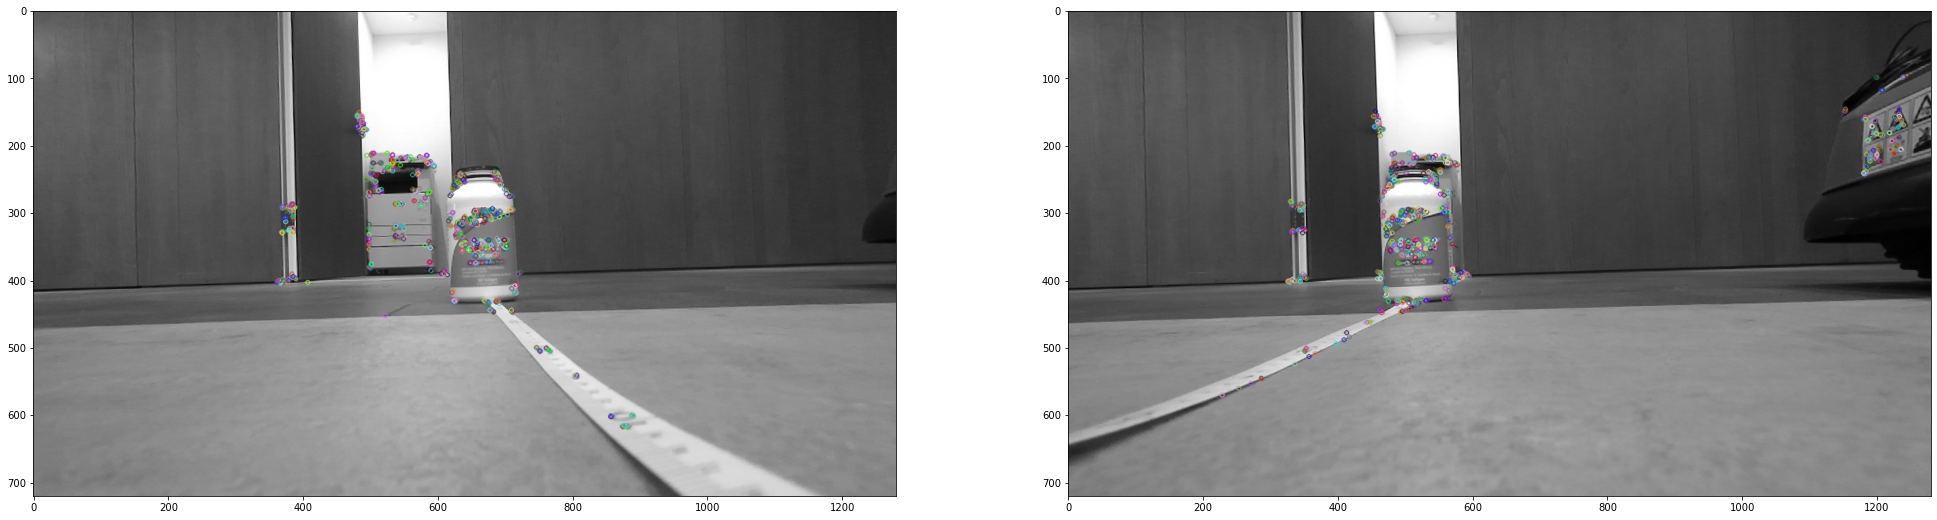

In [396]:
images_orb = []
for img in images_zed:
    img, kp, des = compute_orb_keypoints(img)
    image_orb = cv2.drawKeypoints(img, kp, None)
    kps.append(kp)
    images_orb.append(image_orb)

plt.rcParams["figure.figsize"] = (34,12)
plt.subplot(121)
plt.imshow(images_orb[0])
plt.subplot(122)
plt.imshow(images_orb[1])